# Tide spectral analysis.
In this notebook we are focusing on water level observations collected at two different french stations:

 - Brest in Brittany
   
 - Macinaggio in Corsica
   
We aim to describe the contributions of the different tide harmonic on the total signal

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import pandas as pd

from scipy.stats.distributions import chi2
from scipy.signal import welch

In [2]:
def confident_interval_spec_95(Ef, n_spec):
    """ The 95% confident interval of the spectrum
    input: 
    Ef: The Power Spectral Density (PSD)
    n_spec: Number of spectra used for the mean PSD
    
    outputs:
    Ef_low: The low PSD
    Ef_up: The up PSD
    """
    low_bound=0.025
    up_bound=0.975
    Ef_low=chi2.ppf(low_bound, df=2*n_spec)*Ef/(2*n_spec)
    Ef_up=chi2.ppf(up_bound, df=2*n_spec)*Ef/(2*n_spec)
    
    return Ef_low,Ef_up

### Load data

In [3]:
ds_corsica = xr.open_dataset('./data/tide_corsica.nc')
ds_brest = xr.open_dataset('./data/tide_brest.nc')
ds_brest = ds_brest.rename({'TIME':'time'}) # see you can also modify very easely the dimension/variables of the DataArray with Xarray

In [4]:
ds_brest

<xarray.Dataset> Size: 518kB
Dimensions:    (time: 43155)
Coordinates:
  * time       (time) datetime64[ns] 345kB 2024-01-01 ... 2024-10-29
Data variables:
    LATITUDE   float32 4B ...
    LONGITUDE  float32 4B ...
    sea_level  (time) float32 173kB ...
Attributes:
    title:           BREST
    subtitle:        3
    description:     Dataset containing observation groups for sources: [2]
    history:         Created 20/10/25
    conventions:     CF-1.7
    time_system:     UTC
    netcdf_version:  netCDF-4 classic model
    institution:     Shom
    contact:         refmar@shom.fr
    references:      https://data.shom.fr/donnees/refmar/3

Plot the Signal. Look at the range of the water elevation difference between the two stations

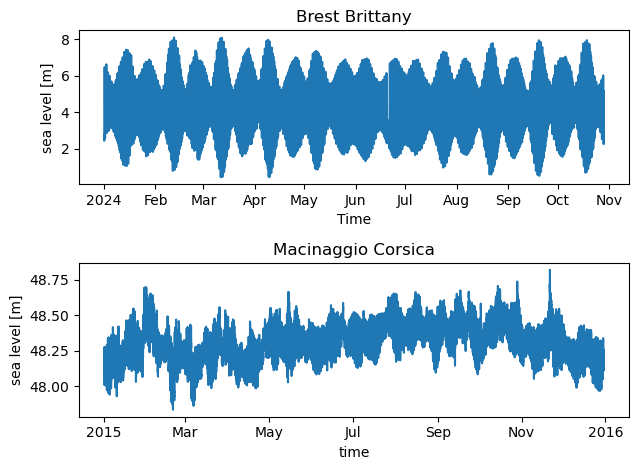

In [5]:
fig, axes = plt.subplots(nrows = 2)

ax = axes[0]
ds_brest.sea_level.plot(ax = ax)
ax.set_ylabel('sea level [m]')
ax.set_title('Brest Brittany')
ax = axes[1]
ds_corsica.sea_level.plot(ax = ax)
ax.set_title('Macinaggio Corsica')
ax.set_ylabel('sea level [m]')
plt.tight_layout()

### Spectral Analysis.
Here we use the Welch method from the scipy.signal package. It yields the same results as our functions we developed in the [previous notebook](./spectral_analysis_on_geo_record.ipynb)

In [6]:
########
#--- compute the time step of the dataset.
########
dt_brest = np.diff(ds_brest.time) 
dt_corsica = np.diff(ds_corsica.time)
print(f'The mean dt for the Brest s dataset is {dt_brest.mean()}') 
print(f'The mean dt for the Macinaggio s dataset is {dt_corsica.mean()}')

########
#--- Interp the Data along a new time axis
########
new_time_axis_brest = np.arange(ds_brest.time[0].values, ds_brest.time[-1].values, dt_brest.mean()).astype('datetime64[ns]')
new_time_axis_corsica = np.arange(ds_corsica.time[0].values, ds_corsica.time[-1].values, dt_corsica.mean()).astype('datetime64[ns]')

ds_brest_interp = ds_brest.interp(time=new_time_axis_brest)
ds_corsica = ds_corsica.interp(time=new_time_axis_corsica)
# see how easy it is to perform the interpolation with Xarray (default linear interpolation)

The mean dt for the Brest s dataset is 604643833711 nanoseconds
The mean dt for the Macinaggio s dataset is 900187541177 nanoseconds


In [7]:
number_of_point_per_window = 2000 # this is my choice
ns_to_sec = 1e9 # from sec to ns
number_of_point_for_fft = len(ds_corsica.sea_level.values)
#########
# ---  Compute the water level spectra 
#########
f1, psd1 = welch(ds_brest.sea_level.values, fs = 1/(float(dt_brest.mean())) * ns_to_sec, nperseg = number_of_point_per_window,\
                 nfft = number_of_point_for_fft, window = 'hann', detrend = 'constant', scaling = 'density') # for Brest observations

n_spec_1 = int(number_of_point_for_fft/number_of_point_per_window) # the number of windows

number_of_point_for_fft = len(np.squeeze(ds_corsica.sea_level.values))
f2, psd2 = welch(np.squeeze(ds_corsica.sea_level.values), fs = 1/(float(dt_corsica.mean())) * ns_to_sec, nperseg = number_of_point_per_window,\
                 nfft = number_of_point_for_fft, window = 'hann', detrend = 'constant', scaling = 'density') # for Macinaggio observations

n_spec_2 = int(number_of_point_for_fft/number_of_point_per_window) # the number of windows

#########
# ---  Confident interval
#########
psd_1_down, psd_1_up = confident_interval_spec_95(psd1, n_spec_1)
psd_2_down, psd_2_up = confident_interval_spec_95(psd2, n_spec_2)

These are the frequencies of the main harmonics of the tide

In [8]:


tide_harmonics = pd.DataFrame({
    "Constituent": ["name_1", "name_2", "name_3", "name_4", "name_5", "name_6"],
    "Description": [
        "tidal_const_1",
        "tidal_const_2",
        "tidal_const_3",
        "tidal_const_4",
        "tidal_const_5",
        "tidal_const_6"
    ],
    # Frequencies in Hertz (1/s)
    "Frequency(cpday)": [
        1/(12.421*3600),
        1/(12*3600),
        1/(23.9*3500),
        1/(8.28*3600),
        1/(6.21*3600),
        1/(4.14*3600)
        
    ]
})


frequencies = tide_harmonics["Frequency(cpday)"].to_numpy()


### Plot the Spectra and their Uncertainties


(0.05, 10000000)

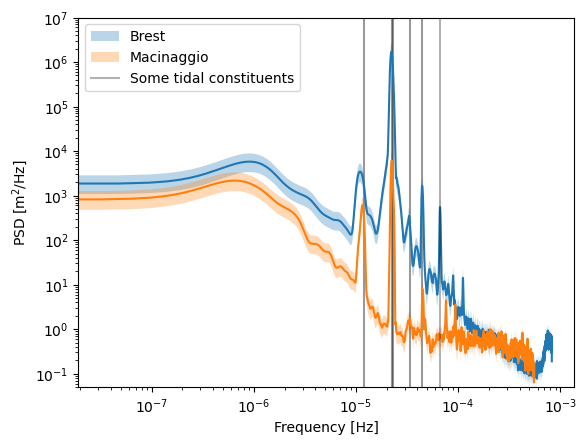

In [9]:
y_min, y_max = 5*10**(-2), 1*10**(7)
fig, ax = plt.subplots()
for freq in frequencies[:-1]:
    ax.plot([freq, freq], [y_min, y_max], color = 'k', alpha = .4)
ax.loglog(f1, psd1)
ax.fill_between(f1, psd_1_down, psd_1_up, alpha = .3, label = 'Brest')
ax.loglog(f2, psd2)
ax.fill_between(f2, psd_2_down, psd_2_up, alpha = .3, label = 'Macinaggio')
ax.plot([frequencies[-1], frequencies[-1]], [y_min, y_max], color = 'k', alpha = .3, label = 'Some tidal constituents')

ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [m$^2$/Hz]')
ax.set_ylim([y_min, y_max])

Their are distinct peaks in the spectra, both for data collected in Macinaggio and Brest in opposition to the surface gravity waves spectra showed on previous [notebooks](./spectral_analysis_on_geo_record.ipynb) which privided more continuous spectra. All these peaks are centered on the what we call the tidal harmonics, highlight with the vertical lines. They show the contributions of different astral objects. The main contribution is from the semi-diurnal lunar tide called M2 (12 hours and 25 minutes period). Note that the moon has more than one constituents, for instance its declination or its orbital angle on the quatorial plan also play a role.

The variance is higher in the Brest data across the frequency range, indicating stronger tidal amplitudes than in Macinaggio. Although the M2 peak amplitude is similar at both sites, the higher PSD values in Brest suggest larger water level variations. This will be further illustrated in the physical space through a harmonic analysis in the next notebook.